In [64]:
%load_ext autoreload
%autoreload 2

import os, json

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import numpy as np
import scipy as sp
import scipy.stats as stats
import nibabel as nb
import cortex

%matplotlib inline

base_dir = '/Users/knapen/Desktop/prf_lyon/'
os.chdir(base_dir)

with open(os.path.join(base_dir, 'analysis', 'settings.json')) as f:
    json_s = f.read()
    analysis_info = json.loads(json_s)
    
fs_dir = '/Users/knapen/disks/ae_S/2018/visual/seq_test/prf_lyon/derivatives/freesurfer'

N_PROCS = 8

# trying deperately to optimize for speed
import ctypes
# conda_dir = os.environ['CONDA_PREFIX']
conda_dir = '/Users/knapen/miniconda3/envs/py36'
mkl_rt = ctypes.CDLL(os.path.join(conda_dir, 'lib', 'libmkl_rt.dylib'))
mkl_rt.mkl_set_num_threads(ctypes.byref(ctypes.c_int(N_PROCS)))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


507864080

In [4]:
sub = 'sub-01'

input_file = os.path.join(base_dir, 'data', sub, 'func', \
    sub+'_task-prf_acq-median_T1w_desc-preproc_bold.nii.gz')
dm_file = os.path.join(base_dir, 'data', sub, 'dm_out.npy')
    
mask_file = nb.load(os.path.join(base_dir, 'data', sub, 'func', \
     sub+'_task-prf_dir-AP_run-1_space-T1w_desc-brain_mask.nii.gz'))
mask = mask_file.get_data().astype(bool)

# for registration into pycortex
example_epi_file = os.path.join(base_dir, 'data', sub, 'func', \
     sub+'_task-prf_dir-AP_run-1_space-T1w_boldref.nii.gz')
T1_file = os.path.join(base_dir, 'data', sub, 'anat', \
     sub+'_desc-preproc_T1w.nii.gz')
fs_T1_file = os.path.join(base_dir, 'data', sub, 'anat', \
     'T1.nii.gz')

#design matrix
visual_dm = np.load(dm_file).T

# data
in_file_nii = nb.load(input_file)
data = in_file_nii.get_data().reshape((-1,in_file_nii.shape[-1]))

In [5]:
fit_model = analysis_info["fit_model"]

# Fit: define search grids
x_grid_bound = (-analysis_info["max_eccen"], analysis_info["max_eccen"])
y_grid_bound = (-analysis_info["max_eccen"], analysis_info["max_eccen"])
sigma_grid_bound = (analysis_info["min_size"], analysis_info["max_size"])
n_grid_bound = (analysis_info["min_n"], analysis_info["max_n"])
grid_steps = analysis_info["grid_steps"]

# Fit: define search bounds
x_fit_bound = (-analysis_info["max_eccen"]*2, analysis_info["max_eccen"]*2)
y_fit_bound = (-analysis_info["max_eccen"]*2, analysis_info["max_eccen"]*2)
sigma_fit_bound = (1e-6, 1e2)
n_fit_bound = (1e-6, 2)
beta_fit_bound = (-1e6, 1e6)
baseline_fit_bound = (-1e6, 1e6)

if fit_model == 'gauss' or fit_model == 'gauss_sg':
    bound_grids  = (x_grid_bound, y_grid_bound, sigma_grid_bound)
    bound_fits = (x_fit_bound, y_fit_bound, sigma_fit_bound, beta_fit_bound, baseline_fit_bound)
elif fit_model == 'css' or fit_model == 'css_sg':
    bound_grids  = (x_grid_bound, y_grid_bound, sigma_grid_bound, n_grid_bound)
    bound_fits = (x_fit_bound, y_fit_bound, sigma_fit_bound, n_fit_bound, beta_fit_bound, baseline_fit_bound)

In [17]:
# this is spoofing it, of course. We should create an actual package.
os.chdir(os.path.join(base_dir, 'analysis'))
from prf_fit import *

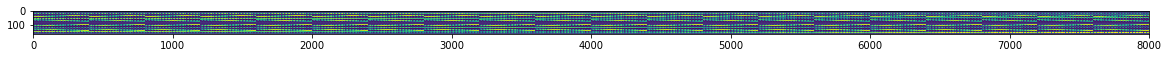

In [5]:
# intitialize prf analysis
prf = PRF_fit(  data = data[mask.ravel()],
                fit_model = fit_model, 
                visual_design = visual_dm, 
                screen_distance = analysis_info["screen_distance"],
                screen_width = analysis_info["screen_width"],
                scale_factor = 1/2.0, 
                tr =  analysis_info["TR"],
                bound_grids = bound_grids,
                grid_steps = grid_steps,
                bound_fits = bound_fits,
                n_jobs = N_PROCS,
                sg_filter_window_length = analysis_info["sg_filt_window_length"],
                sg_filter_polyorder = analysis_info["sg_filt_polyorder"],
                sg_filter_deriv = analysis_info["sg_filt_deriv"], 
                )
# will need to move/delete this file for new predictions
prediction_file = os.path.join(base_dir, 'data', 'sub-01', 'predictions.npy')
if os.path.isfile(prediction_file):
    prf.load_grid_predictions(prediction_file=prediction_file)
else:
    prf.make_predictions(out_file=prediction_file)

plt.figure(figsize=(20,12))
plt.imshow(prf.predictions)

In [6]:
prf.grid_fit()

100%|██████████| 8000/8000 [1:12:17<00:00,  1.84it/s]


AttributeError: 'PRF_fit' object has no attribute 'prf_xs'

#### Save out outputs

In [8]:
rsq_output = np.zeros(mask_file.shape)
rsq_output[mask] = prf.gridsearch_r2
rsq_out_nii = nb.Nifti1Image(rsq_output, affine=mask_file.affine, header=mask_file.header)
rsq_out_nii.to_filename(os.path.join(base_dir, 'data', sub, 'rsq.nii.gz'))

In [21]:
params_output = np.zeros(list(mask_file.shape) + [prf.prediction_params.shape[0]])
params_output[mask] = prf.prediction_params.T
params_out_nii = nb.Nifti1Image(params_output, affine=mask_file.affine, header=mask_file.header)
params_out_nii.to_filename(os.path.join(base_dir, 'data', sub, 'params.nii.gz'))

### Surface stuff

In [72]:
rsq_threshold = 0.1

t = np.sqrt(rsq_threshold)/(np.sqrt((1-rsq_threshold)/(analysis_info['n_timepoints_per_run']-2)))
p = stats.t.sf(t, analysis_info['n_timepoints_per_run']-1)

print('Voxel admission threshold info: \np={p}, t={t}, correlation={r}'.format(p=p, t=t, r=np.sqrt(rsq_threshold)))

Voxel admission threshold info: 
p=1.5643603123014424e-05, t=4.281744192888376, correlation=0.31622776601683794


In [41]:
# only run this once for each subject
# cortex.freesurfer.import_subj(
#         subject=sub, sname=sub, freesurfer_subject_dir=fs_dir)
# and this too, once it works :)
# xfm_data = np.eye(4)
# xfm_data = np.loadtxt(os.path.join(base_dir, 'data', sub, 'func', 'flirt.mtx'))
# xfm = cortex.xfm.Transform.from_fsl(xfm=xfm_data, 
#                                     func_nii=example_epi_file, 
#                                     anat_nii=fs_T1_file)
# # Save as pycortex 'coord' transform
# xfm.save(sub, 'fmriprep_T1', 'coord')

In [59]:
params = nb.load(os.path.join(base_dir, 'data', sub, 'params.nii.gz'))
p_data = params.get_data()
rsq = nb.load(os.path.join(base_dir, 'data', sub, 'rsq.nii.gz')).get_data()

# now construct polar angle and eccentricity values
complex_location = p_data[...,0] + p_data[...,1] * 1j
polar_angle = np.angle(complex_location)
eccentricity = np.abs(complex_location)

size = p_data[...,2]
# baseline and beta were swapped when running the first fits.
baseline = p_data[...,3]
beta = p_data[...,4]

polar_angle_n = (polar_angle + np.pi) / (np.pi * 2.0)

# make discrete angles for clarity
angle_offset = 0.1
polar_angle_n = np.fmod(polar_angle_n+angle_offset, 1.0)

# convert angles to colors, using correlations as weights
hsv = np.zeros(list(polar_angle_n.shape) + [3])
hsv[..., 0] = polar_angle_n # angs_discrete  # angs_n
hsv[..., 1] = np.ones_like(rsq) # np.sqrt(rsq) #np.ones_like(rsq)  # np.sqrt(rsq)
hsv[..., 2] = np.ones_like(rsq)  # np.sqrt(rsq)# np.ones_like(rsq)

alpha_mask = (rsq <= rsq_threshold).T
# alpha = np.sqrt(rsq).T * 5
# alpha[alpha_mask] = 0
alpha = np.ones(alpha.shape)
alpha[alpha_mask] = 0

rgb = colors.hsv_to_rgb(hsv)

In [60]:
vrgba = cortex.VolumeRGB(
    red=rgb[..., 0].T,
    green=rgb[..., 1].T,
    blue=rgb[..., 2].T,
    subject=sub,
    alpha=alpha,
    xfmname='fmriprep_T1')
vecc = cortex.Volume2D(eccentricity.T, rsq.T, sub, 'fmriprep_T1',
                           vmin=0, vmax=10,
                           vmin2=rsq_threshold, vmax2=1.0, cmap='BROYG_2D')
vsize = cortex.Volume2D(size.T, rsq.T, sub, 'fmriprep_T1',
                           vmin=0, vmax=10,
                           vmin2=rsq_threshold, vmax2=1.0, cmap='BROYG_2D')
vbeta = cortex.Volume2D(beta.T, rsq.T, sub, 'fmriprep_T1',
                           vmin=-2.5, vmax=2.5,
                           vmin2=rsq_threshold, vmax2=1.0, cmap='RdBu_r_alpha')
vbaseline = cortex.Volume2D(baseline.T, rsq.T, sub, 'fmriprep_T1',
                           vmin=-1, vmax=1,
                           vmin2=rsq_threshold, vmax2=1.0, cmap='RdBu_r_alpha')
vrsq = cortex.Volume2D(rsq.T, rsq.T, sub, 'fmriprep_T1',
                           vmin=0, vmax=0.8,
                           vmin2=rsq_threshold, vmax2=1.0, cmap='fire_alpha')


ds = cortex.Dataset(polar=vrgba, ecc=vecc, size=vsize, amplitude=vbeta, baseline=vbaseline, rsq=vrsq)
handle = cortex.webgl.show(data=ds, recache=True, port=12001)

Generating new ctm file...
wm
wm
inflated
inflated
Stopping server
Started server on port 12001
Stopping server


In [61]:
ds.save(os.path.join(base_dir, 'data', sub, 'pycortex_ds.h5'))
cortex.webgl.make_static(os.path.join(base_dir, 'data', sub, 'pycortex_html'), ds)